In [1]:
!hostnamectl

   Static hostname: psh01com1hcom01
         Icon name: computer-server
           Chassis: server
        Machine ID: 47b3d6fb06e0455987f8fbd8b72bfe4d
           Boot ID: c7eb6b77c2974a2f85c3c3f3710c29e2
  Operating System: ]8;;https://www.redhat.com/Red Hat Enterprise Linux 8.10 (Ootpa)]8;;
       CPE OS Name: cpe:/o:redhat:enterprise_linux:8::baseos
            Kernel: Linux 4.18.0-553.22.1.el8_10.x86_64
      Architecture: x86-64


In [2]:

import os
import pandas as pd
import matplotlib.pyplot as plt
import dev.notebooks.plotting as dev_plots
from typing import Union
import importlib
from grn_inference.utils import read_ground_truth

## Reload dev_plots

In [20]:
importlib.reload(dev_plots)

<module 'dev.notebooks.plotting' from '/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py'>

# Comparing Different Methods for Calculating and Evaluating Sliding Window Scores

We have two methods for calculating TF-TG binding scores: 

1. Sum TF binding potential for all peaks targeting the same TG
2. Use individual TF-peak-TG scores

We also have different methods for assigning peaks to TGs
1. Nearest gene TSS to the peak
2. MIRA peak-TG
3. Cicero peak-TG

To evaluate the accuracy of the TF-TG scores, we will use the ChIP-seq ground truth, where the TG for TF-peak edges is assigned using the closest gene's TSS.

We will test the combinations of the calculation methods with the peak-TG assignments to see which are more discriminatory

##  Sliding Window Score Calculation

The sliding window score distributions are different for each TF depending on the TF's binding motif. To determine the probability that each TF will bind to each peak, the probabilities need to be standardized to account for these differences.

### Method 1: Summing peaks for TF-TG edges

The sliding window score for a peak will be determined by dividing the sum of the sliding window scores for a given TG by the sliding window score of all other sliding window scores for the TF:

$$\text{Sliding Window Score}_{\text{TF-TG}} = \frac{\sum_{\text{peak} \in \text{TG Peaks}}^{\text{TG peaks}}\text{sliding window score}_{\text{peak}}}{\sum \text{Total sliding window scores}_{\text{TF}}}$$

In [4]:
def calculate_summed_tf_tg_score(sliding_window_with_targets: pd.DataFrame):
    # Group by TF and sum all sliding window scores
    sum_of_tf_peaks = (
        sliding_window_with_targets
        .groupby("source_id")["sliding_window_score"]
        .sum()
        .reset_index()
        .rename(columns={"sliding_window_score":"total_tf_score"})
        )
    
    # Group by TF-TG edge and sum for all peaks for that edge
    sum_of_tf_tg_peak_scores = (
        sliding_window_with_targets
        .groupby(["source_id", "target_id"])["sliding_window_score"]
        .sum()
        .reset_index()
        .rename(columns={"sliding_window_score":"tf_to_tg_peak_scores_summed"})
        )
    
    # Merge the total TF peaks and summed TF-TG edges
    sliding_window_sum_calculation_df = pd.merge(
        sum_of_tf_tg_peak_scores, 
        sum_of_tf_peaks, 
        how="left", 
        on="source_id"
        )
    
    
    sliding_window_sum_calculation_df["sliding_window_score"] = (
        sliding_window_sum_calculation_df["tf_to_tg_peak_scores_summed"] / sliding_window_sum_calculation_df["total_tf_score"]
        ) * 1e6
    sliding_window_sum_df = sliding_window_sum_calculation_df[["source_id", "target_id", "sliding_window_score"]]
    
    return sliding_window_sum_df

### Method 2: Individual peaks for TF-TG edges

We also want to evaluate the performance of using each TF-peak-TG score rather than aggregating. For this, we use the following formula:

$$\text{Sliding Window Score}_{\text{TF-peak-TG}} = \frac{\text{sliding window score}_{\text{TF-peak-TG}}}{\sum \text{Total sliding window scores}_{\text{TF}}}$$

In [5]:
def calculate_tf_peak_tg_score(sliding_window_with_targets: pd.DataFrame):
    # Group by TF and sum all sliding window scores
    sum_of_tf_peaks = (
        sliding_window_with_targets
        .groupby("source_id")["sliding_window_score"]
        .sum()
        .reset_index()
        .rename(columns={"sliding_window_score":"total_tf_score"})
        )
    
    # Merge the total TF peaks with the TF-peak-TG scores
    sliding_window_tf_peak_tg_calculation_df = pd.merge(
        sliding_window_with_targets, 
        sum_of_tf_peaks, 
        how="left", 
        on="source_id"
        ).rename(columns={"sliding_window_score":"tf_peak_tg_score"})
    
    # Calculate the final sliding window score by dividing each TF-peak-TG score by the sum of scores for the TF
    sliding_window_tf_peak_tg_calculation_df["sliding_window_score"] = (
        sliding_window_tf_peak_tg_calculation_df["tf_peak_tg_score"] / sliding_window_tf_peak_tg_calculation_df["total_tf_score"]
        ) * 1e6
    sliding_window_tf_peak_tg_df = sliding_window_tf_peak_tg_calculation_df[["source_id", "peak_id", "target_id", "sliding_window_score"]]
    
    return sliding_window_tf_peak_tg_df

## Functions for assigning peaks to TGs

### Assigning TG as nearest gene TSS to peak

In [9]:
def set_tg_as_closest_gene_tss(raw_sliding_window_scores: pd.DataFrame, peaks_gene_distance_file: str):
    # Read in the peaks to TG data and pick the closest gene for each peak (maximum TSS distance score)
    peaks_near_genes_df = pd.read_parquet(peaks_gene_distance_file, engine="pyarrow")

    closest_gene_to_peak_df = peaks_near_genes_df.sort_values("TSS_dist_score", ascending=False).groupby("peak_id").first()
    closest_gene_to_peak_df = closest_gene_to_peak_df[["target_id"]].reset_index()

    # Set the TG for each TF-peak edge as the closest gene to the peak
    sliding_window_closest_gene_df = pd.merge(raw_sliding_window_scores, closest_gene_to_peak_df, on=["peak_id"], how="left")
    return sliding_window_closest_gene_df

### Assigning TG using MIRA peak-TG

In [10]:
def set_tg_using_mira_peak_tg_edges(raw_sliding_window_scores: pd.DataFrame, mira_df: pd.DataFrame):
    sliding_window_mira_df = pd.merge(raw_sliding_window_scores, mira_df, on=["peak_id"], how="left")
    sliding_window_mira_df = sliding_window_mira_df[["source_id", "peak_id", "target_id", "sliding_window_score"]].dropna(subset="target_id")
    
    return sliding_window_mira_df

### Assigning TG using Cicero peak-TG

In [11]:
def set_tg_using_cicero_peak_tg_edges(raw_sliding_window_scores: pd.DataFrame, cicero_df: pd.DataFrame):
    sliding_window_cicero_df = pd.merge(raw_sliding_window_scores, cicero_df, on=["peak_id"], how="left")
    sliding_window_cicero_df = sliding_window_cicero_df[["source_id", "peak_id", "target_id", "sliding_window_score"]].dropna(subset="target_id")
    
    return sliding_window_cicero_df

## Loading the RN111 and RN115 Ground Truth Datasets

### Loading RN111

In [7]:
rn111_chipseq_ground_truth = read_ground_truth("/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SC_MO_TRN_DB.MIRA/REPOSITORY/CURRENT/REFERENCE_NETWORKS/RN111_ChIPSeq_BEELINE_Mouse_ESC.tsv").drop(columns=["Relationship"])
rn111_chipseq_ground_truth['source_id'] = rn111_chipseq_ground_truth['source_id'].str.capitalize()
rn111_chipseq_ground_truth['target_id'] = rn111_chipseq_ground_truth['target_id'].str.capitalize()

### Loading RN115

In [6]:
rn115_ko_ground_truth = pd.read_csv("/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SC_MO_TRN_DB.MIRA/REPOSITORY/CURRENT/REFERENCE_NETWORKS/RN115_LOGOF_ESCAPE_Mouse_ESC.tsv", sep="\t")
rn115_ko_ground_truth = rn115_ko_ground_truth[["Source", "Target"]].rename(columns={"Source":"source_id", "Target":"target_id"})
rn115_ko_ground_truth["source_id"] = rn115_ko_ground_truth["source_id"].str.capitalize()
rn115_ko_ground_truth["target_id"] = rn115_ko_ground_truth["target_id"].str.capitalize()

### Merging TF-TG dataframes with the ground truth

In [8]:
def merge_dataset_with_ground_truth(df: pd.DataFrame, ground_truth: pd.DataFrame):
    df['source_id'] = df['source_id'].str.capitalize()
    df['target_id'] = df['target_id'].str.capitalize()
    
    shared_sources = set(df['source_id']) & set(ground_truth['source_id'])
    shared_targets = set(df['target_id']) & set(ground_truth['target_id'])

    df_filtered = df[
        df['source_id'].isin(shared_sources) &
        df['target_id'].isin(shared_targets)
    ]

    gt_filtered = ground_truth[
        ground_truth['source_id'].isin(shared_sources) &
        ground_truth['target_id'].isin(shared_targets)
    ]
    
    df_merged = pd.merge(df_filtered, gt_filtered, on=['source_id', 'target_id'], how='outer', indicator=True)
    
    df_merged["label"] = df_merged["_merge"] == "both"
    
    df_labeled = df_merged.drop(columns=["_merge"])
    
    return df_labeled

## mESC Filtered L2 E7.5 Rep1

We first need to read in the sliding window scores, peak to gene distances, MIRA peak-TG scores, and the Cicero peak-TG scores for the mESC filtered L2 E7.5 Rep1 dataset.

### Reading in the peak-TG score files

In [13]:
mesc_output_dir = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/mESC/filtered_L2_E7.5_rep1"
mesc_sliding_window_df = pd.read_parquet(os.path.join(mesc_output_dir, "no_norm_sliding_window_tf_to_peak_score.parquet"), engine="pyarrow")

mesc_peak_to_gene_distance_file = pd.read_parquet(os.path.join(mesc_output_dir, "tmp/peaks_near_genes.parquet"), engine="pyarrow")
mesc_mira_df = pd.read_parquet("/gpfs/Home/esm5360/MIRA/mira-datasets/mESC_filtered_L2_E7.5_rep1/mESC_E7.5_rep1_mira_peak_to_tg_scores_nonzero.parquet", engine="pyarrow")
mesc_cicero_peak_to_tg_df = pd.read_parquet(os.path.join(mesc_output_dir, "cicero_peak_to_tg_scores.parquet"), engine="pyarrow")

### Setting the TGs for the TF-peak edges using closest TSS, MIRA, or Cicero

There are three methods we are using to set the TG for each edge in the TF-peak sliding window dataframe:

1. Closest gene TSS to the peak
2. MIRA peak-TG edges
3. Cicero peak-TG edges

We use the functions defined in the **Functions for assigning peaks to TGs** section to create these datasets

In [12]:
mesc_gene_tss_sliding_window_df = set_tg_as_closest_gene_tss(mesc_sliding_window_df, mesc_peak_to_gene_distance_file)
mesc_mira_sliding_window_df = set_tg_using_mira_peak_tg_edges(mesc_sliding_window_df, mesc_mira_df)
mesc_cicero_sliding_window_df = set_tg_using_cicero_peak_tg_edges(mesc_sliding_window_df, mesc_cicero_peak_to_tg_df)

## DS011

Next, I will evaluate the combinations for DS011. We will load in the sliding window scores and the different peak to TG files we will use to set the TGs for the TF-peak edges.

### Reading in the peak-TG score files

In [ ]:
ds011_output_dir = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/DS011_mESC/DS011_mESC_sample1/"
ds011_sliding_window_df = pd.read_parquet(os.path.join(ds011_output_dir, "no_norm_sliding_window_tf_to_peak_score.parquet"), engine="pyarrow")

ds011_peak_to_gene_distance_file = os.path.join(ds011_output_dir, "peaks_near_genes.parquet")
ds011_mira_df = pd.read_parquet("/gpfs/Home/esm5360/MIRA/mira-datasets/ds011_full/ds011_full_mira_peak_to_tg_scores.parquet", engine="pyarrow")
ds011_cicero_peak_to_tg_df = pd.read_parquet(os.path.join(ds011_output_dir, "cicero_peak_to_tg_scores.parquet"), engine="pyarrow")

### Setting the TGs for the TF-peak edges using closest TSS, MIRA, or Cicero

In [15]:
ds011_gene_tss_sliding_window_df = set_tg_as_closest_gene_tss(ds011_sliding_window_df, ds011_peak_to_gene_distance_file)
ds011_mira_sliding_window_df = set_tg_using_mira_peak_tg_edges(ds011_sliding_window_df, ds011_mira_df)
ds011_cicero_sliding_window_df = set_tg_using_cicero_peak_tg_edges(ds011_sliding_window_df, ds011_cicero_peak_to_tg_df)

### Evaluating summed TF-TG scores

#### Sum peaks for each TG and divide by the sum of TF scores

In [17]:
ds011_gene_tss_tf_tg_sum_df = calculate_summed_tf_tg_score(ds011_gene_tss_sliding_window_df)
ds011_mira_tf_tg_sum_df = calculate_summed_tf_tg_score(ds011_mira_sliding_window_df)
ds011_cicero_tf_tg_sum_df = calculate_summed_tf_tg_score(ds011_cicero_sliding_window_df)

#### Label edges using RN111

In [18]:
ds011_gene_tss_tf_tg_sum_rn111_df = merge_dataset_with_ground_truth(ds011_gene_tss_tf_tg_sum_df, rn111_chipseq_ground_truth)
ds011_mira_tf_tg_sum_rn111_df = merge_dataset_with_ground_truth(ds011_mira_tf_tg_sum_df, rn111_chipseq_ground_truth)
ds011_cicero_tf_tg_sum_rn111_df = merge_dataset_with_ground_truth(ds011_cicero_tf_tg_sum_df, rn111_chipseq_ground_truth)

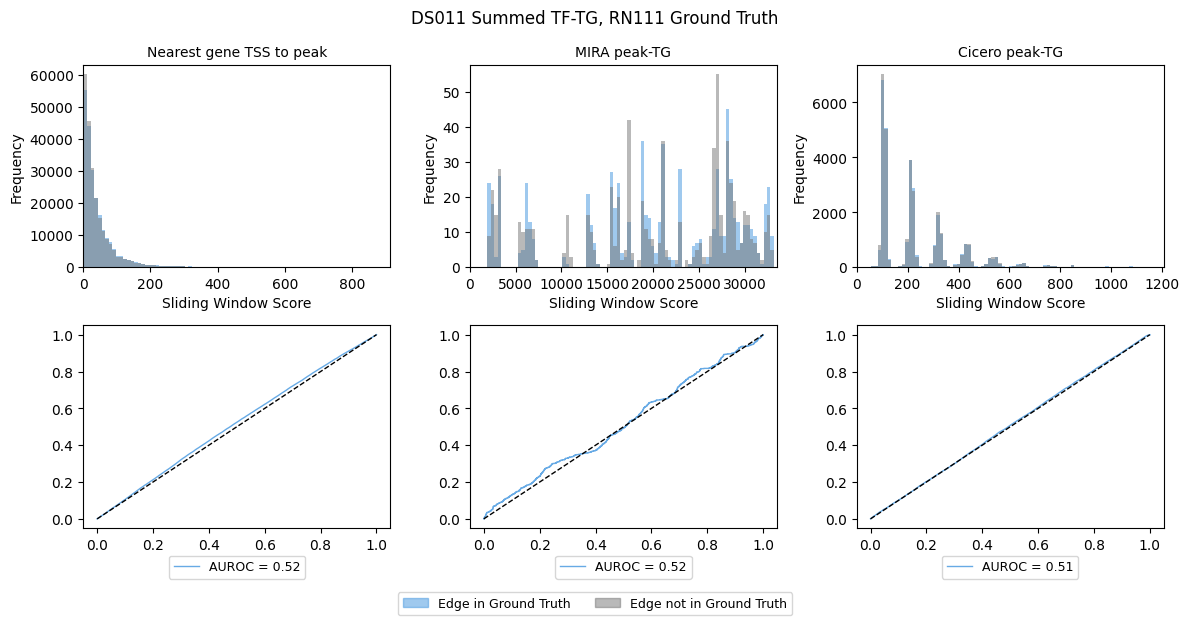

In [21]:
fig = dev_plots.tg_assignment_multiplot(
    nearest_tss_df=ds011_gene_tss_tf_tg_sum_rn111_df,
    mira_df=ds011_mira_tf_tg_sum_rn111_df,
    cicero_df=ds011_cicero_tf_tg_sum_rn111_df,
    suptitle="DS011 Summed TF-TG, RN111 Ground Truth"
)

#### Label edges using RN115

In [22]:
ds011_gene_tss_tf_tg_sum_rn115_df = merge_dataset_with_ground_truth(ds011_gene_tss_tf_tg_sum_df, rn115_ko_ground_truth)
ds011_mira_tf_tg_sum_rn115_df = merge_dataset_with_ground_truth(ds011_mira_tf_tg_sum_df, rn115_ko_ground_truth)
ds011_cicero_tf_tg_sum_rn115_df = merge_dataset_with_ground_truth(ds011_cicero_tf_tg_sum_df, rn115_ko_ground_truth)

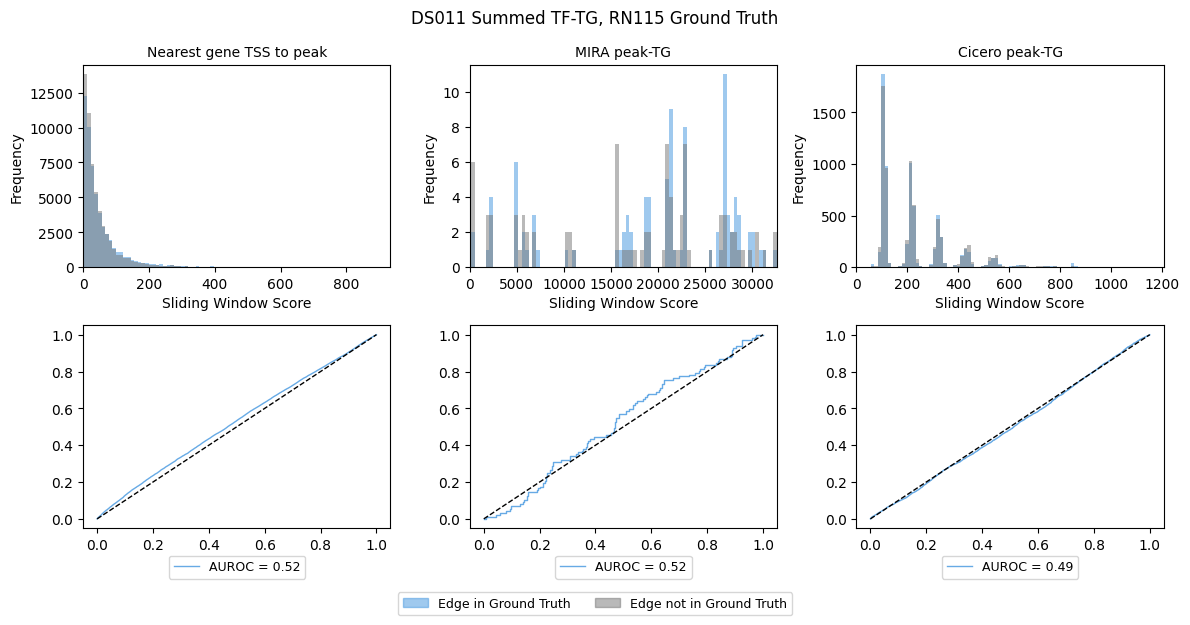

In [23]:
fig = dev_plots.tg_assignment_multiplot(
    nearest_tss_df=ds011_gene_tss_tf_tg_sum_rn115_df,
    mira_df=ds011_mira_tf_tg_sum_rn115_df,
    cicero_df=ds011_cicero_tf_tg_sum_rn115_df,
    suptitle="DS011 Summed TF-TG, RN115 Ground Truth"
)

---

### Evaluating individual TF-peak-TG scores

#### Dividing individual TF-peak-TG scores by the sum of TF scores

In [24]:
ds011_gene_tss_tf_peak_tg_df = calculate_tf_peak_tg_score(ds011_gene_tss_sliding_window_df)
ds011_mira_tf_peak_tg_df = calculate_tf_peak_tg_score(ds011_mira_sliding_window_df)
ds011_cicero_tf_peak_tg_df = calculate_tf_peak_tg_score(ds011_cicero_sliding_window_df)

#### Label edges using RN111

In [25]:
ds011_gene_tss_tf_peak_tg_rn111_df = merge_dataset_with_ground_truth(ds011_gene_tss_tf_peak_tg_df, rn111_chipseq_ground_truth)
ds011_mira_tf_peak_tg_rn111_df = merge_dataset_with_ground_truth(ds011_mira_tf_peak_tg_df, rn111_chipseq_ground_truth)
ds011_cicero_tf_peak_tg_rn111_df = merge_dataset_with_ground_truth(ds011_cicero_tf_peak_tg_df, rn111_chipseq_ground_truth)

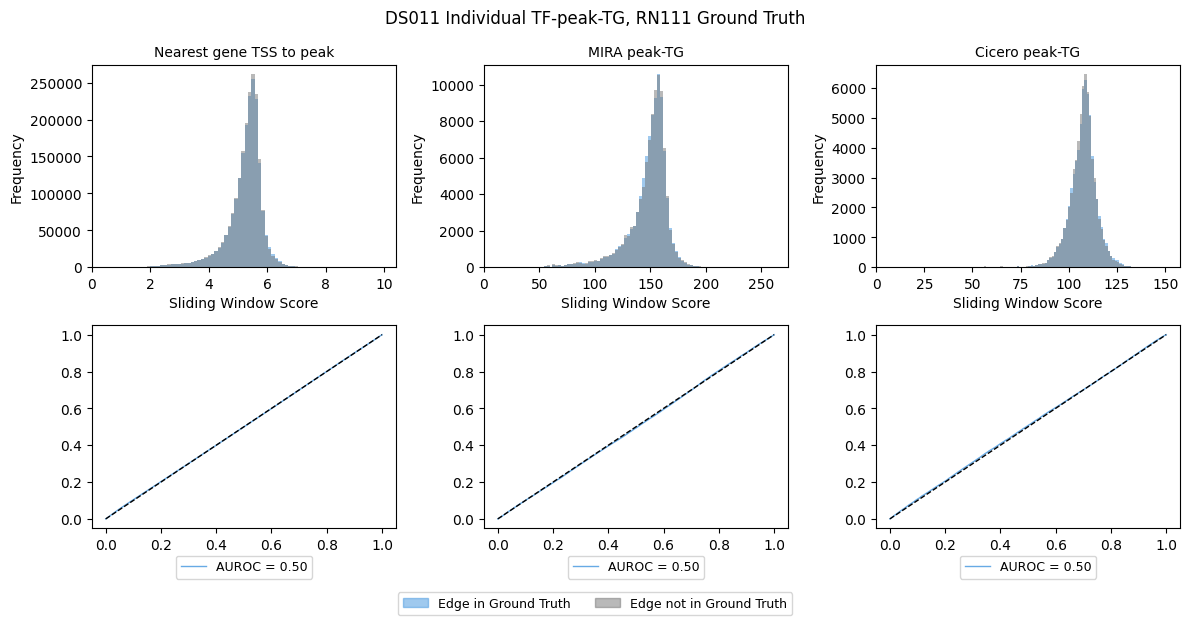

In [26]:
fig = dev_plots.tg_assignment_multiplot(
    nearest_tss_df=ds011_gene_tss_tf_peak_tg_rn111_df,
    mira_df=ds011_mira_tf_peak_tg_rn111_df,
    cicero_df=ds011_cicero_tf_peak_tg_rn111_df,
    suptitle="DS011 Individual TF-peak-TG, RN111 Ground Truth"
)

#### Label edges using RN115

In [ ]:
ds011_gene_tss_tf_peak_tg_rn115_df = merge_dataset_with_ground_truth(ds011_gene_tss_tf_peak_tg_df, rn115_ko_ground_truth)
ds011_mira_tf_peak_tg_rn115_df = merge_dataset_with_ground_truth(ds011_mira_tf_peak_tg_df, rn115_ko_ground_truth)
ds011_cicero_tf_peak_tg_rn115_df = merge_dataset_with_ground_truth(ds011_cicero_tf_peak_tg_df, rn115_ko_ground_truth)

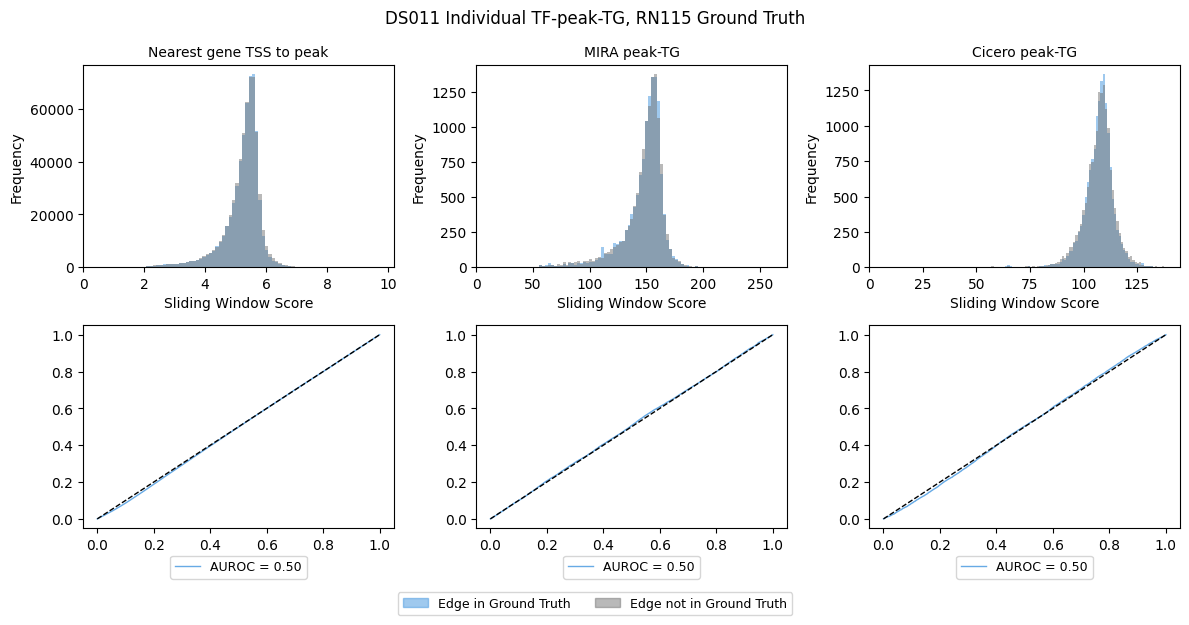

In [ ]:
fig = dev_plots.tg_assignment_multiplot(
    nearest_tss_df=ds011_gene_tss_tf_peak_tg_rn115_df,
    mira_df=ds011_mira_tf_peak_tg_rn115_df,
    cicero_df=ds011_cicero_tf_peak_tg_rn115_df,
    suptitle="DS011 Individual TF-peak-TG, RN115 Ground Truth"
)